# Network Analysis

In this section, we delve into the relationship between celebrity actors and movie ratings. We perform network analysis to evaluate the impact, if any, of different cast combinations on average movie ratings. 
We represent work collaborations among actors with a network graph, where actors are nodes and every edge between two actors indicates a connection them, meaning that they have co-starred in the same movie. 

In [83]:
# Import all libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageDraw
import networkx as nx
import community

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv') 
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')

We check the datasets to ensure that the column entries that we necessitate for the analysis do not have NaN entries. Specifically, for the movies dataset we look at `wikipedia_id`, `freebase_id`, `averageRating`; for actors_info we look at `freebase_actor_id` and `movies`; for the characters dataset we look at `freebase_actor_id` and `freebase_movie_id`. 

In [85]:
movies.isna().sum()

wikipedia_id                   0
freebase_id                    0
name                           0
release_date                   0
revenue                    21460
runtime                        0
languages                      0
countries                      0
genres                         0
year_release                   0
averageRating                  0
numVotes                       0
average_award_cumcount      3702
average_movies_cumcount     3702
award_cumcount              3702
movies_cumcount             3702
dtype: int64

In [86]:
actors_info.isna().sum()

actor_birth           76097
actor_gender          37800
actor_height         121294
actor_etnicity       125974
actor_name                1
freebase_actor_id         1
awards                    0
movies                    1
Fame                      0
Liked                     0
Disliked                  0
Neutral                   0
dtype: int64

In [87]:
characters.isna().sum()

wikipedia_movie_id                 0
freebase_movie_id                  0
movie_release_date                 0
character_name                 90614
actor_birth                    37774
actor_gender                   16299
actor_height                  107893
actor_etnicity                134592
actor_name                       149
actor_age_at_release           56626
freebase_char_actor_map_id         0
freebase_character_id          90610
freebase_actor_id                  0
Fame                               0
Liked                              0
Disliked                           0
Neutral                            0
award_cumcount                     0
movies_cumcount                    0
dtype: int64

We establish that the movies and characters datasets do have NaN values for the columns specified above, whereas 1 actor in the actors_info dataset has missing name, id and movie information; we remove the entry.

In [88]:
# Removing actors without movie information
actors_info = actors_info[actors_info['movies'].notna()]

In order to filter out outdated data, we solely consider movies released in the 21st century. We then merge the movie dataset with the characters dataset to obtain the `freebase_actor_id` of the actors who played in the respective movies. 

In [89]:
# Removing movies from before 2000
movies = movies[movies['year_release'] >= 2000] 

# Rename movies' column 
movies = movies.rename(columns={'freebase_id': 'freebase_movie_id'}) 

# Merging movies with characters on freebase_movie_id
# to get the actors' freebase_actor_id
movies_characters = pd.merge(
    left=movies,
    right=characters,
    left_on="freebase_movie_id",  # Column from the "movies" DataFrame
    right_on="freebase_movie_id"  # Column from the "characters" DataFrame
)

# Filter out duplicates of 'freebase_movie_id' and 'freebase_actor_id'
movies_characters = movies_characters.drop_duplicates(
    subset=["freebase_movie_id", "freebase_actor_id"], keep="first"
)

### One Hot Encoding of Actors

In network analysis, one-hot encoding is often used to convert categorical variables, such as the actors' unique identifier `freebase_actor_id`, into a binary vector representation that can be easily understood by machine learning algorithms. If an actor has a particular freebase_actor_id, the corresponding variable will be set to 1, and all other variables will be set to 0.

One-hot encoding is particularly useful in network analysis because it allows us to capture the relationships between movies and the actors who have worked in them based on their freebase_actor_id. For example, for a movie represented by its unique identifier `wikipedia_id`, if two actors have played in, they will have a value of 1 in the corresponding `freebase_actor_id` variable, indicating that they are connected in some way. This information can be used to analyze the network structure and relationships between actors in the network.

In [90]:
# One Hot Encoding of Actors
actor_one_hot = pd.get_dummies(
    data=movies_characters, columns=["freebase_actor_id"]
)

# Only include wikipedia_id and one hot encoding of actors in dataframe
actor_one_hot = actor_one_hot.filter(
    regex="wikipedia_id|freebase_actor_id_"
)

actor_one_hot.shape

(61752, 35973)

Since there exist over 60'000 movie entries in our current dataframe, we decide to set different thresholds of the number of movies that an actor has played in and to explore how many actors meet that threshold. 
We choose 5, 10, 12 and 15 as threshold values and display a logarithmic plot distibution of the results. 

Number of actors with more than 5 movie appearances: 1581
Number of actors with more than 10 movie appearances: 330
Number of actors with more than 12 movie appearances: 178
Number of actors with more than 15 movie appearances: 50


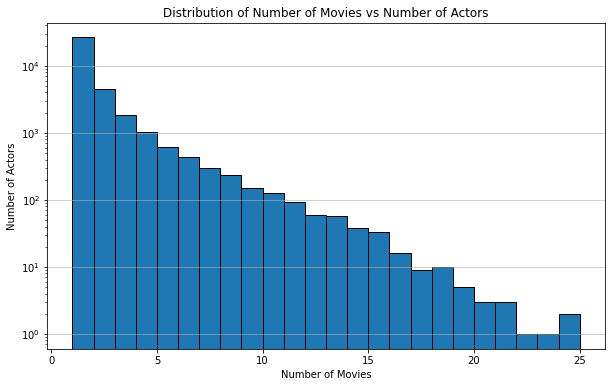

In [91]:
# Create subsets of actor one-hot encoding for different movie count thresholds
actor_one_hot_5 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 5]
actor_one_hot_10 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 10]
actor_one_hot_12 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 12]
actor_one_hot_15 = actor_one_hot.loc[:, actor_one_hot.sum(axis=0) > 15]

# Print the number of actors that have played in more than x movies
print("Number of actors with more than 5 movie appearances: {}".format(actor_one_hot_5.shape[1] - 1))
print("Number of actors with more than 10 movie appearances: {}".format(actor_one_hot_10.shape[1] - 1))
print("Number of actors with more than 12 movie appearances: {}".format(actor_one_hot_12.shape[1] - 1))
print("Number of actors with more than 15 movie appearances: {}".format(actor_one_hot_15.shape[1] - 1))

# Calculate the count of actors for each number of movie appearances
actors_per_movie_count = actor_one_hot.sum(axis=0)

# Remove the count of the "wikipedia_id" column
actors_per_movie_count = actors_per_movie_count.drop("wikipedia_id")

# Create a histrogram with logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
plt.hist(actors_per_movie_count, bins=range(1, actors_per_movie_count.max() + 1), edgecolor='k')
plt.xlabel('Number of Movies')
plt.ylabel('Number of Actors')
plt.title('Distribution of Number of Movies vs Number of Actors')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.show()


We decide to restrict our dataframe to actors who worked in more than 15 movies in order to obtain a visually meaningful netwrok graph. 

In [92]:
actor_one_hot_choice = actor_one_hot_15

We merge the actor_one_hot_choice dataframe with the movies dataframe in order to have direct access to each movie's information and the one-hot encoded actors who played in it. 

In [93]:
# Grouping movies so that each movie corresponds to a single row in the dataframe
movies_grouped_by_actor = actor_one_hot_choice.groupby("wikipedia_id").agg("sum")

# Merging the dummy actor columns with the movie data
movies_actors_one_hot = pd.merge(
    movies, movies_grouped_by_actor, left_on="wikipedia_id", right_index=True
)

# Check the shape of the resulting dataframe
movies_actors_one_hot.shape

(6434, 66)

We generate a graph with acotrs as nodes and connections as edges indicating that the two actors have worked together on a movie. Specifically, the thickness of the edge-connections is proportional to the number of movie collaborations of the respective actor pairs, and the size of the actor-nodes is proportional to the average rating of the movies that the corresponding actor has been in.

In [94]:
# Create an empty graph
G = nx.Graph()

# Initialize dictionaries to store actor ratings and movies
actor_ratings = {}  # Dictionary to store total ratings and movie count for each actor
actor_movies = {}   # Dictionary to store the movies each actor has appeared in

# Iterate over the rows in the movies_actors_one_hot dataframe
for _, row in movies_actors_one_hot.iterrows():
    # Get the movie's rating
    rating = row['averageRating']

    # Get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_id') and row[actor] == 1]
    
    for actor in actors:
        if actor not in actor_ratings:
            actor_ratings[actor] = [rating, 1]  # Store total ratings and movie count for each actor
            G.add_node(actor, size=rating)  # Add actor as a node to the graph with size equal to rating
            actor_movies[actor] = [row['freebase_movie_id']]  # Store the movie that this actor has appeared in
        else: 
            actor_ratings[actor][0] += rating  # Update total ratings for this actor
            actor_ratings[actor][1] += 1  # Update movie count for this actor
            G.nodes[actor]['size'] = actor_ratings[actor][0] / actor_ratings[actor][1]  # Update node size
            actor_movies[actor].append(row['freebase_movie_id'])  # Add this movie to the list of movies for this actor
    
    # Add edges between actors that have played in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            if G.has_edge(actor1, actor2):
                G[actor1][actor2]['weight'] += 1  # Update the weight of the existing edge
            else:
                G.add_edge(actor1, actor2, weight=1)  # Add a new edge with weight 1  

# Update the weight of each edge to be the number of movies that the actors have played in together
for actor1, actor2 in G.edges():
    movies1 = actor_movies[actor1]
    movies2 = actor_movies[actor2]
    weight = len(set(movies1).intersection(movies2))  # Number of movies that both actors have appeared in
    G[actor1][actor2]['weight'] = weight

In [95]:
# Get the number of edges
num_nodes = G.number_of_nodes()
print("The number of nodes in the graph G is:", num_nodes)

# Get the number of edges
num_edges = G.number_of_edges()
print("The number of edges in the graph G is:", num_edges)

The number of nodes in the graph G is: 50
The number of edges in the graph G is: 178


This results in a graph of 50 actor-nodes and 178 edge-connections, displayed below with actor names as node labels, edge-thickness proportional to the number of movie collaborations of the respective actor pairs, and size of the actor-nodes proportional to the average rating of the movies that the corresponding actor has been in.

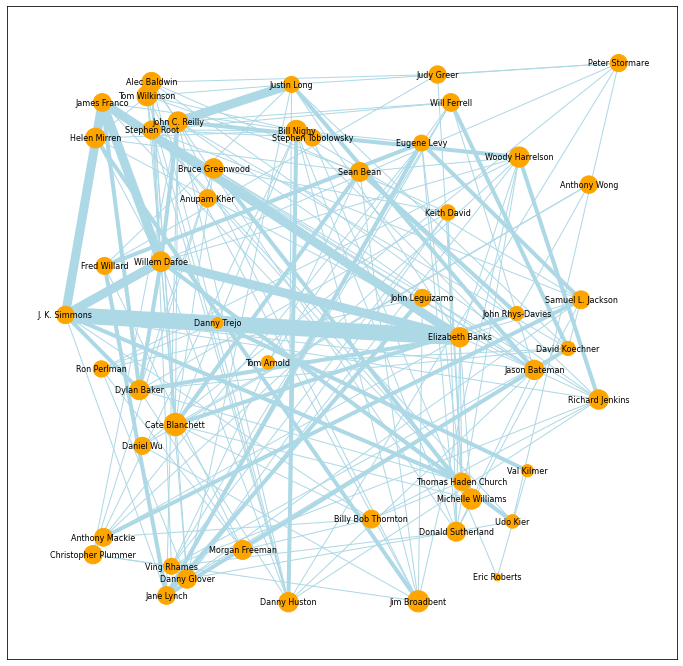

In [96]:
# Create a figure
plt.figure(figsize=(12,12))

# Get the node sizes
node_sizes = nx.get_node_attributes(G, 'size')

# Get the edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')  

# Get the actor names from the characters dataframe
actor_names = characters.set_index('freebase_actor_id')['actor_name'].to_dict()

# Match the actor names to the node IDs
actor_names = {node: actor_names[node.split('_id_')[1]] for node in node_sizes}

# Position the nodes randomly
pos = nx.random_layout(G)

# Rescale the edge weights s.t. the smallest edge is 50 and the largest is 500
node_sizes = {node: node_sizes[node] for node in node_sizes}
node_sizes = {node: (node_sizes[node] - min(node_sizes.values())) / (max(node_sizes.values()) - min(node_sizes.values())) for node in node_sizes}
node_sizes = {node: 50 + 450 * node_sizes[node] for node in node_sizes}

# Draw the nodes with labels
nx.draw_networkx_nodes(G, pos=pos, node_size=[node_sizes[v] for v in G.nodes()], node_color='orange')

# Draw the edges
nx.draw_networkx_edges(G, pos=pos, edge_color='lightblue', width=[w**2 for _, _, w in G.edges(data='weight')])

# Draw the node labels
nx.draw_networkx_labels(G, pos=pos, labels=actor_names, font_size=8)

# Save the plot
plt.savefig('img/actor_network_num_movies.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


We explore the presence of communities among actors in order to gain valuable insights into the relationships and interactions between actors within a movie network. Communities refer to groups of actors who have a higher likelihood of collaborating with each other in movies. By identifying these communities, we can gain a better understanding of the social structure within the movie industry and how it influences various aspects of movie production, in particular whether certain groups of actors consistently work together in movies that receive higher or lower ratings. This information can be useful in determining the impact of actor collaborations on the overall quality of movies. For example, if a particular community consistently produces highly-rated movies, it may indicate that the actors within that community have a strong synergy or shared expertise.

The Girvan-Newman algorithm is a community detection algorithm that iteratively removes edges with the highest betweenness centrality. It is generally a more fine-grained algorithm with higher computational complexity than the Louvain method explained below. 

In [97]:
# # Perform community partitioning using Girvan-Newman method
# communities = list(nx.community.girvan_newman(G))

# # Get the number of communities
# num_communities = len(communities)

# # Print the number of communities
# print("The number of communities detected using Girvan-Newman method is:", num_communities)

The Louvain method is a popular algorithm for community detection in network analysis that works as a two-step iterative process. In the first step, each node is assigned to its own community, while in the second step, the algorithm optimizes the modularity of the network by iteratively merging communities. The Louvain method is known for its efficiency and ability to handle large-scale networks. 

In [98]:
# Detect communities in the graph through the Louvain method 
partition = community.best_partition(G, random_state=1, weight='weight') 

communities = {}

# Partition actors in communities
for actor, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [actor]
    else:
        communities[community_id].append(actor)
        
# Get the number of communities
num_communities = len(communities)
        
print("The number of communities detected using Louvian method is:", num_communities)

The number of communities detected using Louvian method is: 7


Since the Girvan-Newman method results in too many communities (nearly as many as the actors) with a single actor per community, we choose to base our following analyses on the communities detected by the Louvian method.

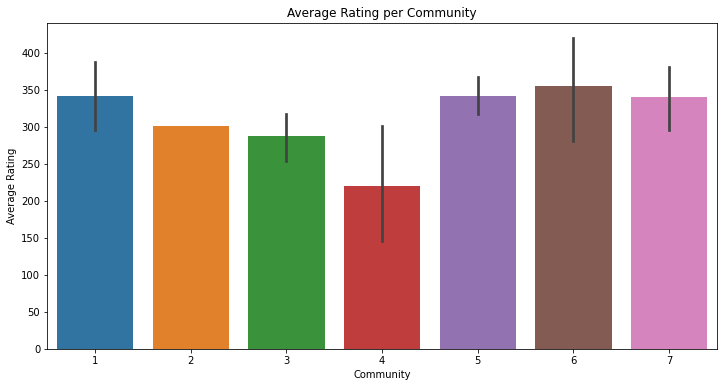

In [99]:
# Create a figure
plt.figure(figsize=(12,6))

# Create a Pandas dataframe from the dictionary
actors = pd.DataFrame.from_dict(partition.items(), orient='columns')

actors.columns = ['actor', 'community']

actors['averageRating'] = actors['actor'].apply(lambda x: node_sizes[x])

ax = sns.barplot(x="community", y="averageRating", data=actors)

plt.xlabel('Community')
plt.ylabel('Average Rating')
plt.title('Average Rating per Community')
plt.xticks([x for x in range(7)], [x for x in range(1, 8)])

# Save the plot in the img folder
plt.savefig('img/community_rating_num_movies.png', dpi=300, bbox_inches='tight')
plt.show()

We conduct ANOVA (Analysis of Variance) to analyze the average ratings of different communities. The goal is to determine if there is a statistically significant difference in the average ratings across these communities.
This ANOVA analysis helps us understand the relationship between the communities and the average ratings, providing valuable insights for further analysis or decision-making.

In [100]:
# ANOVA

# Create a list of average ratings for each community
community_ratings = [actors.loc[actors['community'] == i, 'averageRating'] for i in range(7)]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*community_ratings)

# Output the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the results based on the p-value
if p_value < 0.05:
    print("The difference in average rating across communities is statistically significant.")
else:
    print("There is no statistically significant difference in average rating across communities.")

F-statistic: 2.718249193040265
p-value: 0.025052313464406856
The difference in average rating across communities is statistically significant.


# Causal analysis of cast-diversity influence on movie rating

After having found a statistically significant difference in the average rating (of movies?) from different communities, we want to investigate another thematically similar question: Is it better to pick a all actors for a cast from within a community or should you rather pick actors across communities when you want to achieve a higher movie rating?
#### Method
For this analysis we first calculate the number of actors per community for each movie as well as the total count of considered actors. Afterwards, we calculate different measures for the diversity of the cast. For our continuos diversity indicators we then do a linear regression, while for our binary diversity indicator we first do paired matching and propensity score matching and then do a linear regression.

---
#### Results
* We didn't observe any statistically significant effect of the diversity on the movie rating.
* The diversity measure does not explain the variability in movie ratings. Viewers do not seem to care about how often the actors collaborate or how similar they are in terms of done movies, hence we conclude that they evaluate a movie based on other criteria.
---

### 1. Extend dataframe by diversity measures
While we have done the previous graphs based on actors, that have done at least 15 movies together for better visualizability, we will now continue with the 10-movie-threshold in order to keep enough samples and make statistically relevant statements. We therefore have to first rerun the community detection from the previous chapter.
#### 1.1 Recompute communities

In [101]:
# Continue with 10-movie threshold
actor_one_hot_choice = actor_one_hot_10

# Grouping movies so that each movie corresponds to a single row in the dataframe
movies_grouped_by_actor = actor_one_hot_choice.groupby("wikipedia_id").agg("sum")

# Merging the dummy actor columns with the movie data
movies_actors_one_hot = pd.merge(
    movies, movies_grouped_by_actor, left_on="wikipedia_id", right_index=True
)

# Create an empty graph
G = nx.Graph()

# Initialize dictionaries to store actor ratings and movies
actor_ratings = {}  # Dictionary to store total ratings and movie count for each actor
actor_movies = {}   # Dictionary to store the movies each actor has appeared in

# Iterate over the rows in the movies_actors_one_hot dataframe
for _, row in movies_actors_one_hot.iterrows():
    # Get the movie's rating
    rating = row['averageRating']

    # Get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_id') and row[actor] == 1]
    
    for actor in actors:
        if actor not in actor_ratings:
            actor_ratings[actor] = [rating, 1]  # Store total ratings and movie count for each actor
            G.add_node(actor, size=rating)  # Add actor as a node to the graph with size equal to rating
            actor_movies[actor] = [row['freebase_movie_id']]  # Store the movie that this actor has appeared in
        else: 
            actor_ratings[actor][0] += rating  # Update total ratings for this actor
            actor_ratings[actor][1] += 1  # Update movie count for this actor
            G.nodes[actor]['size'] = actor_ratings[actor][0] / actor_ratings[actor][1]  # Update node size
            actor_movies[actor].append(row['freebase_movie_id'])  # Add this movie to the list of movies for this actor
    
    # Add edges between actors that have played in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            if G.has_edge(actor1, actor2):
                G[actor1][actor2]['weight'] += 1  # Update the weight of the existing edge
            else:
                G.add_edge(actor1, actor2, weight=1)  # Add a new edge with weight 1  

# Update the weight of each edge to be the number of movies that the actors have played in together
for actor1, actor2 in G.edges():
    movies1 = actor_movies[actor1]
    movies2 = actor_movies[actor2]
    weight = len(set(movies1).intersection(movies2))  # Number of movies that both actors have appeared in
    G[actor1][actor2]['weight'] = weight

# Get the number of edges
num_nodes = G.number_of_nodes()
# Print the number of edges
print("The number of nodes in the graph G is:", num_nodes)

# Get the number of edges
num_edges = G.number_of_edges()
# Print the number of edges
print("The number of edges in the graph G is:", num_edges)

# Detect communities in the graph through the Louvain method 
partition = community.best_partition(G, random_state=1, weight='weight') 

communities = {}

# Partition actors in communities
for actor, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [actor]
    else:
        communities[community_id].append(actor)
        
# Get the number of communities
num_communities = len(communities)
        
print("The number of communities detected using Louvian method is:", num_communities)

The number of nodes in the graph G is: 330
The number of edges in the graph G is: 3629
The number of communities detected using Louvian method is: 12


Now that we recomputed our communities with the new threshhold, we can continue by preparing our dataset for the analysis.

#### 1.2 Extend dataset with community counts

First we create a new dataframe in which we include the number of actors per community as well as the total count of considered actors and the number of non-zero communities, per movie respectively.

In [102]:
# Base calculations on previously chosen one-hot-encoding dataframe
movies_one_hot_actors = actor_one_hot_choice.copy()

# Get actor-community mapping in a list
flattened_data = [(actor, community_id) for community_id, actors in communities.items() for actor in actors]
#Convert this list into a DataFrame. This DataFrame will have two columns: one for actor IDs and one for community IDs.
actor_community = pd.DataFrame(flattened_data, columns=['actor_id', 'community_id'])

# Get actor-encoding column names for subsequent melting
actor_columns = [col for col in movies_one_hot_actors.columns if col.startswith('freebase_actor_id_')]

# Reshape one-hot-encoding from wide to long format
long_movies_df = movies_one_hot_actors.melt(id_vars=['wikipedia_id'], 
                                value_vars=actor_columns,
                                var_name='actor_id', 
                                value_name='is_present')

# Filter out rows where the respective actor is not present
long_movies_df = long_movies_df[long_movies_df['is_present'] == 1]

# Include info about community per actor by merging with actor_community
merged_df = long_movies_df.merge(actor_community, on='actor_id')
# Remove the 'freebase_actor_id_' prefix from actor_id
merged_df['actor_id'] = merged_df['actor_id'].str.replace('freebase_actor_id_', '')

# Group by movie and community and count
community_counts = merged_df.groupby(['wikipedia_id', 'community_id']).size().reset_index(name='count')

# Pivot df such that each community count is entered in a separate column
pivoted_df = community_counts.pivot(index='wikipedia_id', columns='community_id', values='count')

# Resetting the index to turn wikipedia_id back into a column
pivoted_df.reset_index(inplace=True)

# Fill NaN values with 0 if there are movies without actors from certain communities
pivoted_df.fillna(0, inplace=True)

# Create a new column 'total_community_count' which is the sum of all community count columns
pivoted_df['total_community_count'] = pivoted_df[pivoted_df.columns[1:]].sum(axis=1)
# Create a new column 'non_zero_communities' which indicates the number communities with at least one actor
pivoted_df['non_zero_communities'] = pivoted_df[pivoted_df.columns[1:-1]].apply(lambda row: sum(x != 0 for x in row), axis=1)

# Rename columns for clarity
pivoted_df.columns = ['wikipedia_id'] + [f'community_{c}_count' for c in pivoted_df.columns[1:-2]] + ['total_community_count'] + ['non_zero_communities']

#Provide final dataframe
mov_com_count = pivoted_df.copy()

display(mov_com_count.head(1))
print(f'Final shape #movies x #columns: {mov_com_count.shape}')

,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,community_11_count,total_community_count,non_zero_communities
0,11242,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,4


Final shape #movies x #columns: (2213, 15)


Before the analysis let's get an idea of the data at hand by looking at a few diagrams.
First, we have a look at the distribution of community counts across all movies and all communities.

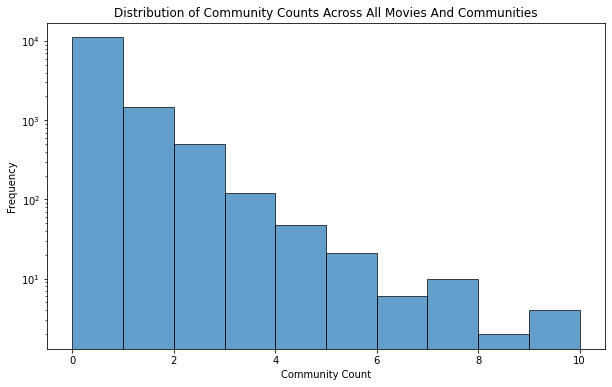

In [124]:
# Extract columns that start with 'community_' and end with '_count'
community_count_columns = [col for col in mov_com_count.columns if col.startswith('community_') and col.endswith('_count')]

# Flatten these columns into a single array
all_community_counts = mov_com_count[community_count_columns].values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_community_counts, edgecolor='black', alpha=0.7)
plt.title('Distribution of Community Counts Across All Movies And Communities')
plt.xlabel('Community Count')
plt.ylabel('Frequency')
plt.yscale('log')

# Save the plot
plt.savefig('img/Distribution_of_ Community_Counts_Across_All_ Movies_And_Communities.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


As seen above, the non-zero counts in the matrix are quite sparse, and the graph suggests an exponential relationship between the number of community members and their frequency. Most of the non-zero counts are ones, with only little movies having casts with several actors from the same community. This is - among other factors - due to the fact that we filtered out actors who haven't done at least 10 movies. Per community there are in general little actors left, as can be seen below.

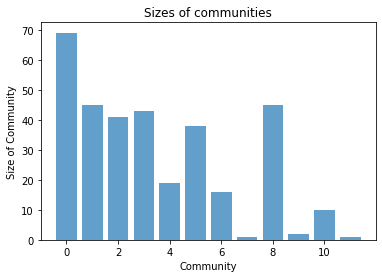

In [104]:
# Extracting the sizes of the communities
sizes = [len(arr) for arr in communities.values()]

# Plotting
plt.bar(communities.keys(), sizes, alpha=0.7)
plt.xlabel('Community')
plt.ylabel('Size of Community')
plt.title('Sizes of communities')

# Save the plot
plt.savefig('img/SizesOfCommunities.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Yet, as seen below, each movie has at least one considered actor! In order to make the cast diversity measures meaningful, we filter out movies that have only one still considered actor left in the cast! This drastically decreases our dataset, but is necessary to keep our findings interpretable!

In [105]:
# Print amount of movies without considered actors
print(f'Number of movies that do not included any actor considered by us: {(mov_com_count["non_zero_communities"] == 0).sum()}')

# Filter out unrepresentative movies with only 1 considered actor!
print(f'Number of movies before filtering: {mov_com_count.shape[0]}')
mov_com_count = mov_com_count[(mov_com_count["total_community_count"] != 1)]
print(f'Number of movies left: {mov_com_count.shape[0]}')

Number of movies that do not included any actor considered by us: 0
Number of movies before filtering: 2213
Number of movies left: 1107


#### 1.3. Calculating Cast Diversity Measures
Now that we have prepared our dataframes and got an idea of the data, we calculate different measures indicating how uniform a cast of a movie is in terms of their community. We calculate three different measures:
1. **Entropy:** Entropy in this context is a measure of diversity or unpredictability. For a cast of a movie, it can be used to quantify how evenly spread the cast members are across different communities. A lower entropy value would suggest that most cast members come from the same or a few communities (more uniform), while a higher value indicates a more diverse cast across many communities.
2. **Gini Coefficient:** Originally used to measure income inequality, the Gini coefficient can be adapted to measure inequality in community representation within a movie's cast. A Gini coefficient of 0 would indicate perfect uniformity (all cast members are from the same community), while a coefficient closer to 1 would indicate high inequality (cast members are evenly spread out across many communities).
3. **Binary Diversity Indicator:** If more than 70% of all considered actors come from the same community, we consider the cast as not being divers.

In [106]:
# Extract indexes of community columns
community_columns = [col for col in mov_com_count.columns if (col.startswith('community_') & col.endswith('count'))]

##### 1.3.1 Entropy
Let's compute the first diversity indicator: Shannon Entropy. We use the following formula for the Shannon entropy:
$$ H(X) = -\sum_{i=1}^{n} P(x_i) \log_2 P(x_i) $$

Where:
- $H(X)$ is the entropy of the distribution of actors across communities in a movie.
- $n$  is the number of communities.
- $P(x_i)$ is the proportion of actors in the $i^{th}$ community relative to the total number of actors in the movie.


In [107]:
mov_entropy = mov_com_count.copy()

# Function to calculate entropy
def calculate_entropy(row):
    # Extracting community counts
    community_counts = row[community_columns].values

    # Calculating the total count to get proportions
    total_count = row['total_community_count']
    if total_count == 0:  # To handle division by zero
        return 0

    # Calculating proportions
    proportions = community_counts / total_count

    # Calculating entropy
    entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])  # Exclude zero proportions
    return entropy

# Applying the function to each row in the DataFrame
mov_entropy['entropy'] = mov_entropy.apply(calculate_entropy, axis=1)

display(mov_entropy.head(1))


,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,community_11_count,total_community_count,non_zero_communities,entropy
0,11242,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,4,1.921928


##### 1.3.2 Gini-Coefficient
Our second diversity indicator is the Gini coefficient. For a discrete probability distribution, the formula for the Gini coefficient can be simplified to:
$$ G = 1 - \sum_{i=1}^{n} P(x_i)^2 $$

Where:
- $G$ is the Gini coefficient.
- $n$ is the number of communities.
- $P(x_i)$ is the proportion of actors in the $i^{th}$ community relative to the total number of actors in the movie.

In [108]:
mov_gini = mov_entropy.copy()

import numpy as np
import pandas as pd

# Function to calculate the Gini coefficient
def calculate_gini(row):
    # Extracting community counts
    community_counts = row[community_columns].values
    
    # Calculating the total count to get proportions
    total_count = row['total_community_count']
    if total_count == 0:  # To handle division by zero
        return 0

    # Calculating proportions
    proportions = community_counts / total_count

    # Calculating Gini coefficient
    gini = 1 - np.sum(proportions ** 2)
    return gini

# Applying the function to each row in the DataFrame
mov_gini['gini_coefficient'] = mov_gini.apply(calculate_gini, axis=1)

display(mov_gini.head(1))

,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,community_11_count,total_community_count,non_zero_communities,entropy,gini_coefficient
0,11242,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,4,1.921928,0.72


##### 1.3.3 Binary Cast-Community Diversity Indicator

Finally we include the binary cast indicator. Our threshold is set to 0.7, meaning that whenever one represented community in a cast provides at least 70% o the actors we consider that cast to be not divers!

In [109]:
threshold = 0.7 # Set threshold here!
mov_bin_comdiv = mov_gini.copy()

# Returns 
def calculate_binary_community_diversity(row):
     # Extracting community counts
    community_counts = row[community_columns].values

    # Return 0 if no communities
    total_count = row['total_community_count']
    if total_count == 0:  # To handle division by zero
        return 1
    
    # Calculating proportions
    proportions = community_counts / total_count


    # Check for threshold and return 0 or one respectively
    # 0 == not divers, 1 == divers
    return 0 if max(proportions) >= threshold else 1

    
# Applying the function to each row in the DataFrame
mov_bin_comdiv['cast_is_community_divers'] = mov_bin_comdiv.apply(calculate_binary_community_diversity, axis=1)

display(mov_bin_comdiv.head(1))
print(f'#movies with divers cast: {mov_bin_comdiv["cast_is_community_divers"].sum()}')
print(f'#movies with non-divers cast: {(mov_bin_comdiv["cast_is_community_divers"] == 0).sum()}')

,wikipedia_id,community_0_count,community_1_count,community_2_count,community_3_count,community_4_count,community_5_count,community_6_count,community_7_count,community_8_count,community_9_count,community_10_count,community_11_count,total_community_count,non_zero_communities,entropy,gini_coefficient,cast_is_community_divers
0,11242,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,4,1.921928,0.72,1


#movies with divers cast: 715
#movies with non-divers cast: 392


Let's examine the distribution of our newly calculated diversity measures.

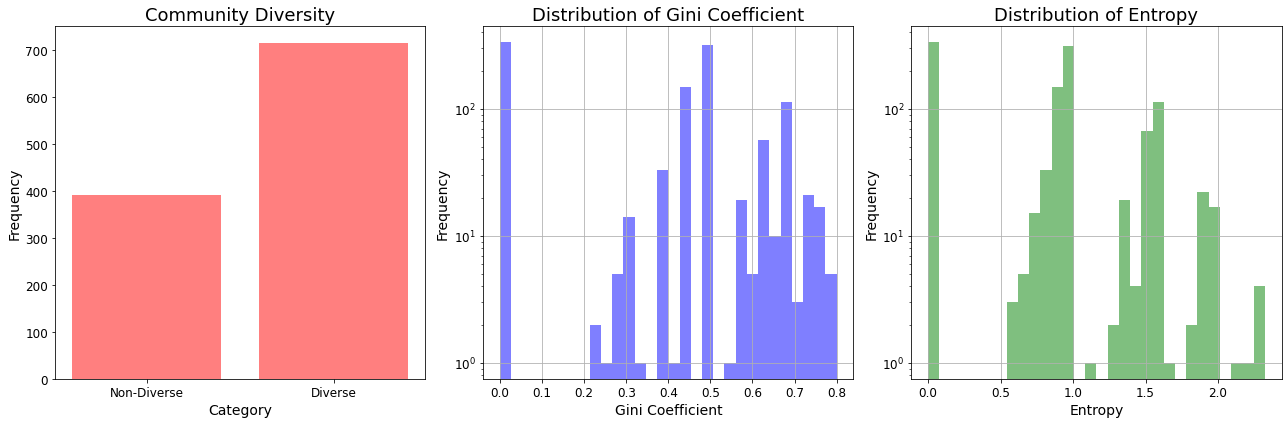

In [132]:
# Define common font size
title_fontsize = 18
label_fontsize = 14
tick_labelsize = 12

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting the distribution of the community diversity based upon threshold
values, counts = np.unique(mov_bin_comdiv['cast_is_community_divers'], return_counts=True)
axes[0].bar(['Non-Diverse', 'Diverse'], counts, color='red', alpha=0.5)
axes[0].set_title('Community Diversity', fontsize=title_fontsize)
axes[0].set_xlabel('Category', fontsize=label_fontsize)
axes[0].set_ylabel('Frequency', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_labelsize)  # Increase tick label size for both axes


# Plotting the distribution of the Gini Coefficient
axes[1].hist(mov_bin_comdiv['gini_coefficient'], bins=30, alpha=0.5, color='blue')
axes[1].set_title('Distribution of Gini Coefficient', fontsize=title_fontsize)
axes[1].set_xlabel('Gini Coefficient', fontsize=label_fontsize)
axes[1].set_ylabel('Frequency', fontsize=label_fontsize)
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=tick_labelsize)  # Increase tick label size for both axes

# Plotting the distribution of Entropy
axes[2].hist(mov_bin_comdiv['entropy'], bins=30, alpha=0.5, color='green')
axes[2].set_title('Distribution of Entropy', fontsize=title_fontsize)
axes[2].set_xlabel('Entropy', fontsize=label_fontsize)
axes[2].set_ylabel('Frequency', fontsize=label_fontsize)
axes[2].set_yscale('log')
axes[2].grid(True)
axes[2].tick_params(axis='both', labelsize=tick_labelsize)  # Increase tick label size for both axes

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('img/distr_of_diversity_measures.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


As expected the diversity measures indicate a high uniformity across movies due to the fact that we often only consider one actor per movie.
The distribution of the Gini coefficient and the distribution of the entropy seem somewhat similar on the first sight, just the scale of the respective variable is slightly different. This shows that both measures serve as an indicator for the same concept, being diversity.

### 2. Conduct Analysis Regarding Cast-Diversity

#### 2.1 Analysis using entropy and Gini coefficient as diversity measure
After all those preparation steps, let's finally look into how the diversity of a cast affects the movie ratings. We will start with the Gini coefficient and then continue with the entropy measure. But beforehand, let's import the necessary libraries and include the averageRating column.

In [111]:
# Import necessary libraries
import statsmodels.formula.api as smf
import ast
# Include necessary columns for matching and propensity-score calculation
original_movies = mov_bin_comdiv.merge(movies, on='wikipedia_id', how='left')
print(original_movies.columns)

Index(['wikipedia_id', 'community_0_count', 'community_1_count',
       'community_2_count', 'community_3_count', 'community_4_count',
       'community_5_count', 'community_6_count', 'community_7_count',
       'community_8_count', 'community_9_count', 'community_10_count',
       'community_11_count', 'total_community_count', 'non_zero_communities',
       'entropy', 'gini_coefficient', 'cast_is_community_divers',
       'freebase_movie_id', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'year_release', 'averageRating',
       'numVotes', 'average_award_cumcount', 'average_movies_cumcount',
       'award_cumcount', 'movies_cumcount'],
      dtype='object')


Before conducting a regression, let's first look into how our data is distributed using scatterplots! By plotting the samples we try to identify a relationship between the diversity and the ratings. This can help in choosing the right regression model for our task. 

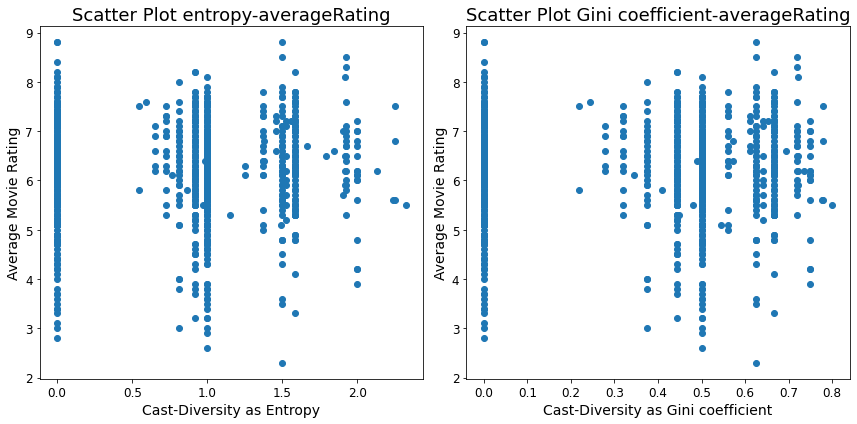

In [133]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(original_movies['entropy'], original_movies['averageRating'])
axes[0].set_xlabel('Cast-Diversity as Entropy', fontsize=label_fontsize)
axes[0].set_ylabel('Average Movie Rating', fontsize=label_fontsize)
axes[0].set_title('Scatter Plot entropy-averageRating', fontsize=title_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_labelsize)  # Increase tick label size for both axes

axes[1].scatter(original_movies['gini_coefficient'], original_movies['averageRating'])
axes[1].set_xlabel('Cast-Diversity as Gini coefficient', fontsize=label_fontsize)
axes[1].set_ylabel('Average Movie Rating', fontsize=label_fontsize)
axes[1].set_title('Scatter Plot Gini coefficient-averageRating', fontsize=title_fontsize)
axes[1].tick_params(axis='both', labelsize=tick_labelsize)  # Increase tick label size for both axes

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('img/scatter_of_diversity_measures.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In the diagrams above no clear relationship between the diversity and the movie ratings is identifiable.

In [113]:
# Conduct linear regression of entropy on averageRating
# Define formula
formula = 'averageRating ~ entropy'

# Initialize linear regression model
mod = smf.ols(formula=formula, data=original_movies)

# Fit the model
res = mod.fit()

# Print the results
print("Linear Regression Of Entropy On Average Movie Rating:")
print(res.summary())

Linear Regression Of Entropy On Average Movie Rating:
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.081
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.149
Time:                        20:01:27   Log-Likelihood:                -1556.0
No. Observations:                1107   AIC:                             3116.
Df Residuals:                    1105   BIC:                             3126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [114]:
# Conduct linear regression of Gini coefficient on averageRating
# Define formula
formula = 'averageRating ~ gini_coefficient'

# Initialize linear regression model
mod = smf.ols(formula=formula, data=original_movies)

# Fit the model
res = mod.fit()

# Print the results
print("Linear Regression Of Gini Coefficient On Average Movie Rating:")
print(res.summary())

Linear Regression Of Gini Coefficient On Average Movie Rating:
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.122
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.290
Time:                        20:01:27   Log-Likelihood:                -1556.5
No. Observations:                1107   AIC:                             3117.
Df Residuals:                    1105   BIC:                             3127.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

When using the entropy and the gini coefficient we don't observe statistically significant covariates. Also for these models the R-squared values indicate, that these measures don't explain the rating variability, which was expected due to the observation on the scatterplot.  These results suggest that there is no correlation of the cast diversity on the movie rating. Let us anyway look into our simpler more interpretable binary measure for diversity and it's effects on movie ratings.

### 2.2 Linear regression using binary diversity indicator
#### 2.2.1 Balance dataset by matching

Before we examine the effect that our binary diversity of a cast has on its rating, we have to account for potential confounders. For our binary diversity indicator, we can therefore do paired-matching and match additionally based on the propensity score.
First, we calculate the propensity score including the following standardized variables:
* number of languages
* number of targeted countries
* release year
* runtime

In [115]:
# convert all dicts in string form to actual dictionaries
original_movies['languages'] = original_movies['languages'].apply(ast.literal_eval)
original_movies['countries'] = original_movies['countries'].apply(ast.literal_eval)
original_movies['genres'] = original_movies['genres'].apply(ast.literal_eval)

# Calculate relevant variables for propensity score
original_movies['num_languages'] = original_movies['languages'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
original_movies['num_countries'] = original_movies['countries'].apply(lambda x: len(x) if isinstance(x, dict) else 0)

# Standardize
original_movies['year_release'] = (original_movies['year_release'] - original_movies['year_release'].mean())/original_movies['year_release'].std()
original_movies['num_languages'] = (original_movies['num_languages'] - original_movies['num_languages'].mean())/original_movies['num_languages'].std()
original_movies['num_countries'] = (original_movies['num_countries'] - original_movies['num_countries'].mean())/original_movies['num_countries'].std()

# compute propensity score
formula = 'cast_is_community_divers ~  year_release + num_languages + num_countries'

# initialize the model
mod = smf.logit(formula=formula, data=original_movies)

# fit the model
res = mod.fit()

# add propensity score to the dataframe
original_movies['propensity_score'] = res.predict(original_movies[['year_release', 'num_languages', 'num_countries']])

# print the results
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.648782
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     cast_is_community_divers   No. Observations:                 1107
Model:                                Logit   Df Residuals:                     1103
Method:                                 MLE   Df Model:                            3
Date:                      Fri, 22 Dec 2023   Pseudo R-squ.:                0.001804
Time:                              20:01:28   Log-Likelihood:                -718.20
converged:                             True   LL-Null:                       -719.50
Covariance Type:                  nonrobust   LLR p-value:                    0.4583
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6028      0.063      9.574      0.

Now we can match based on the similarity of certain attributes and the previously calculated propensity score.
To ensure a certain similarity, we only match samples with a difference in the propensity scores below 0.05. Additionally we do paired-matching on the following facts:
* movies should share at least a genre
* movies should share at least a language
* movies should share at least a targeted country

In [116]:
# Declare helper function to be used for paired-matching
from typing import Dict
def shared_value(dict1: Dict, dict2: Dict, min_shared_threshold: int = 1) -> bool:
    """
    Determine if two dictionaries share a certain number of values.

    Args:
    dict1 (Dict): First dictionary.
    dict2 (Dict): Second dictionary.
    min_shared_threshold (int): Minimum number of shared values required.

    Returns:
    bool: True if the dictionaries share at least `min_shared_threshold` values, False otherwise.
    """
    shared_values = set(dict1.values()) & set(dict2.values())
    return len(shared_values) >= min_shared_threshold

In [117]:
# try matching with requirement on genre and similarity
treatment = original_movies[original_movies['cast_is_community_divers'] == 1]
control = original_movies[original_movies['cast_is_community_divers'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treatment.iterrows():

        # Calculate difference
        difference = np.abs(control_row['propensity_score'] - treatment_row['propensity_score'])
        
        
        # Only include samples with similar propensity scores and other shared values
        if shared_value(control_row['genres'], treatment_row['genres'], min_shared_threshold=1) \
            and shared_value(control_row['languages'], treatment_row['languages'], min_shared_threshold=1) \
            and shared_value(control_row['countries'], treatment_row['countries'], min_shared_threshold=1) \
            and difference < 0.05:
            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, difference)])

# Generate the maximum weight matching on the generated graph
min_weight_matching = nx.min_weight_matching(G)

# collect matched instances
matched_movies = [i[0] for i in list(min_weight_matching)] + [i[1] for i in list(min_weight_matching)]

# create the balanced dataset
balanced_movie_df = original_movies.iloc[matched_movies].copy()
print("Number of movies in balanced dataframe: ", balanced_movie_df.shape[0])


Number of movies in balanced dataframe:  660


#### 2.2.2 Linear regression

Now that we balanced our dataset by accounting for potential confounders, we can analyse the effect that the diversity of a cast indicated by our binary measure has on the ratings.
Very important to notice here though is, that our balanced dataset only includes 660 movies. Hence any result can merely provide a hint on what might be true, as the number of movies is too small to provide statistically powerful results.

First, let's examine the difference in average movie ratings between our balanced and unbalanced datasets as well as between divers and non-divers casts

In [118]:
print(
    f'''
    Unbalanced Dataset:
    Avg. movie rating of divers movie casts: {original_movies[original_movies["cast_is_community_divers"] == 1]["averageRating"].mean()}
    Avg. movie rating of non-divers movie casts: {original_movies[original_movies["cast_is_community_divers"] == 0]["averageRating"].mean()}
    
    Balanced Dataset:
    Avg. movie rating of divers movie casts: {balanced_movie_df[original_movies["cast_is_community_divers"] == 1]["averageRating"].mean()}
    Avg. movie rating of non-divers movie casts: {balanced_movie_df[original_movies["cast_is_community_divers"] == 0]["averageRating"].mean()}
    '''
)


    Unbalanced Dataset:
    Avg. movie rating of divers movie casts: 6.2023776223776235
    Avg. movie rating of non-divers movie casts: 6.179591836734693
    
    Balanced Dataset:
    Avg. movie rating of divers movie casts: 6.223939393939393
    Avg. movie rating of non-divers movie casts: 6.2281818181818185
    


Only a very very small difference in the ratings can be identified, no matter if the dataset was matched or not matched.

Now, let's analyse the impact using linear regression. We will compare results using our balanced and unbalanced dataset.

Regression analysis results using UNBALANCED dataset
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1345
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.714
Time:                        21:22:08   Log-Likelihood:                -1556.9
No. Observations:                1107   AIC:                             3118.
Df Residuals:                    1105   BIC:                             3128.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

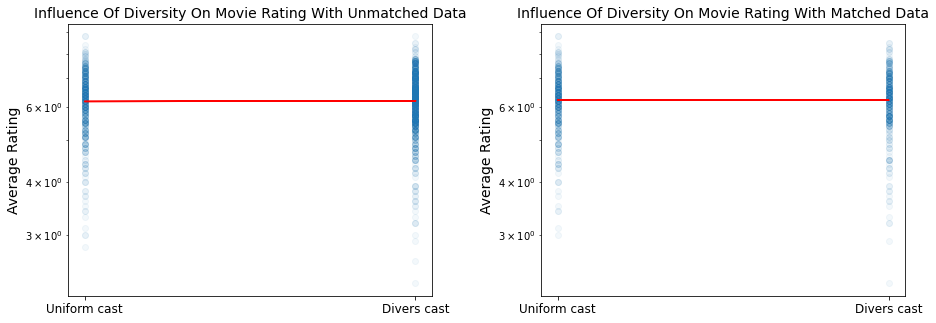

In [140]:
# Declare and fit the model with unbalanced data
print("Regression analysis results using UNBALANCED dataset")
naive_model = smf.ols(formula="averageRating ~ cast_is_community_divers", data=original_movies)
naive_res = naive_model.fit()
print(naive_res.summary())

# Declare and fit the model with balanced data
print("Regression analysis results using BALANCED dataset")
matched_model = smf.ols(formula="averageRating ~ cast_is_community_divers", data=balanced_movie_df)
matched_res = matched_model.fit()
print(matched_res.summary())

# Print the coefficients and p-values
print(
    f'''
    Coefficient for the treatment without matching:     {round(naive_res.params['cast_is_community_divers'], 3)}
    Coefficient for the treatment with matching:         {round(matched_res.params['cast_is_community_divers'], 3)}
    Difference in percent:                                 {round((matched_res.params['cast_is_community_divers'] - naive_res.params['cast_is_community_divers'])/naive_res.params['cast_is_community_divers']*100, 2)}%
    
    p-value for the treatment without matching:          {round(naive_res.pvalues['cast_is_community_divers'], 3)}
    p-value for the treatment with matching:             {round(matched_res.pvalues['cast_is_community_divers'], 3)}
    '''
)
# plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the models
# Style plot based on unmatched data
axes[0].scatter(original_movies['cast_is_community_divers'], original_movies['averageRating'], alpha=0.05)
axes[0].plot(original_movies['cast_is_community_divers'], naive_res.fittedvalues, color='red')
axes[0].set_yscale('log')
axes[0].set_title('Influence Of Diversity On Movie Rating With Unmatched Data', fontsize=14)
axes[0].set_ylabel('Average Rating', fontsize=label_fontsize)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Uniform cast', 'Divers cast'])
axes[0].tick_params(axis='both', labelsize=tick_labelsize)  # Increase tick label size for both axes

# Style plot based on matched data 
axes[1].scatter(balanced_movie_df['cast_is_community_divers'], balanced_movie_df['averageRating'], alpha=0.05)
axes[1].plot(balanced_movie_df['cast_is_community_divers'], matched_res.fittedvalues, color='red')
axes[1].set_yscale('log')
axes[1].set_title('Influence Of Diversity On Movie Rating With Matched Data', fontsize=14)
axes[1].set_ylabel('Average Rating', fontsize=label_fontsize)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Uniform cast', 'Divers cast'])
axes[1].tick_params(axis='both', labelsize=tick_labelsize)  # Increase tick label size for both axes

# Separate the plots using whitespace
plt.subplots_adjust(wspace=0.3)

plt.savefig('img/matched_vs_unmatched.png')

# show the plot
plt.show()

Also here our model is not statistically significant while the R-squared value is extremely low. These findings don't have the same statistical power as when we were using our continuos diversity measures above though because of the much smaller sample. They still indicate though that the diversity has no or a negligible effect on the movie ratings.

To conclude, the found coefficients are not statistically significant and additionally the R-squared values for all our regression models in this analysis part are extremely small! That means that, the diversity of a cast does not explain the variability of the movie ratings. Additionally, even if our last model was statistically significant, the very small difference in average movie ratings would make this finding practically irrelevant.
From that we conclude that other variables but not the cast diversity are responsible for making a movie receive good ratings or bad ratings. The viewer in the end does not care about if the actors have worked together before or not, this is not what makes a movie good or bad.
